<font color="#483D8B">
<h1  align="left">     4710 Lab 8</h1>
<div align="left">
<font size=3><b>
<br>Reccomendation System
<br>Kevin Yang
<br>March 27, 2019
<br></font></b></div>


---------------

## Overview

This lab will focus on a Recommendation System for books. A Recommendation System is mainly an information filtering system that utilizes previous preferences or ratings to predict future preferences or ratings. This lab will work with Popularity Recommenders and Content Filtering to build a Recommendation System.  

References:
1. https://docs.google.com/document/d/1SeH96FCc5MxFCm0tKTh0GDe2DhDfpmI9_derP83GFXk/edit
2. https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847
3. http://www2.informatik.uni-freiburg.de/~cziegler/BX/ (Dataset Link with background information)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import surprise as surp
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import time
import datetime
from surprise.model_selection import GridSearchCV

## Data

The Book-Crossing dataset will be utilized for this lab. The dataset can be found above in 'References'. 
The Book-Crossing dataset contains 3 tables: BX-Users, BX-Books, and BX-Book-Ratings.  

BX-Users contains data about the users. User IDs (`User-ID`) have been anonymized and mapped to integers. Demographic data is provided (`Location`, `Age`) for each user if available. Otherwise, these fields will contain NULL-values. NULL-values meaning 'no value given'.

BX-Books contains data about the books. Books are identified by their ISBN number with invalid ISBNs removed from the dataset. Content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), that are obtained from Amazon Web Services (AWS). Book-Author contains only the first author (some books contain many authors, but this lab will work specifically with only one author). URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site. 

BX-Book-Ratings contains the rating information for the books. Ratings (`Book-Rating`) are either explicit (1-10 scale, higher values indicating higher appreciation), or implicit, expressed by 0.


In [2]:
book_rate = pd.read_csv('C:/Users/kyang/Desktop/BX-Book-Ratings.csv', sep=';',error_bad_lines=False,encoding="latin-1")
book_rate.columns = ['UserID','ISBN','BookRating']

books = pd.read_csv('C:/Users/kyang/Desktop/BX-Books.csv', sep=';',error_bad_lines=False,encoding="latin-1")
books.columns = ['ISBN','BookTitle','BookAuthor','YearOfPublication','Publisher','ImageURLS','ImageURLM','ImageURLL']

users = pd.read_csv('C:/Users/kyang/Desktop/BX-Users.csv', sep=';',error_bad_lines=False,encoding="latin-1")
users.columns = ['UserID','Location','Age']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\kyang\Anaconda3\lib\site-packages\IPython\core\interactiveshell.p

Each data table from the dataset is stored in their appropriate variables. BX-Book-Rate is stored in 'book_rate'. BX-Books is stored in 'books'. BX-Users is stored in 'users'. A large dataset will require separations and organizations, which is accomplished by manually storing the column names into 'columns' of each stored variable.  

## Exploratory Data Analysis

In [3]:
print(book_rate.shape)
print(books.shape)
print(users.shape)

(1149780, 3)
(271360, 8)
(278858, 3)


The dimension for each table is printed above. The book ratings is a larger dataset compared to books and users. 

In [4]:
book_rate.head()

,UserID,ISBN,BookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Above displays a few rows of the data in book ratings. We can see that each book rating is derived from a specific user (UserID) for the specific book(ISBN). 

In [5]:
## BOOKS

In [6]:
books.head()

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher,ImageURLS,ImageURLM,ImageURLL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Books dataset contains more columns compared to the book rating table. We can equate the ISBN number to the ISBN number in the book rating table. Together, we can have the rating for the book and all of its details such as the title, book author, year of publication, publisher and its cover image. Although, there are data that are uneccessary for this analysis, mainly the image URLs that we can drop/remove for this lab.

In [7]:
books.drop(['ImageURLS','ImageURLM','ImageURLL'],axis=1,inplace=True)

The line of code above drops the URL link to the images for each book. 

In [8]:
books.head()

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Showing the head data of 'books' again, we can see the Image URL links have been successfully dropped.

In [9]:
books.dtypes

ISBN                 object
BookTitle            object
BookAuthor           object
YearOfPublication    object
Publisher            object
dtype: object

The data type for each column in 'books' is shown. All columns are 'object' datatypes.

In [10]:
pd.set_option('display.max_colwidth',-1)

'set_option' adjusts the column width to display full text of the columns.

In [11]:
## YEAR OF PUBLICATION

In [12]:
books.YearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Above displays the unique values in the 'books' data regarding the years of publication. We can see that different data types are mixed with some being integers and strings. There is an error with strings 'DK Publishing Inc' and 'Gallimard', which might be due to operations of reading the 'books' data.

In [13]:
books.loc[books.YearOfPublication == 'DK Publishing Inc',:]

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


To fix the error, I will start by locating 'DK Publishing Inc' in the YearOfPublication data region(column). We can see the two books that are were missing from the unique values.

In [14]:
books.loc[books.ISBN == '0789466953','YearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','BookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','BookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life(Level 4: Proficient Readers)"

The YearOfPublication was not an integer(year). I've manually assigned the appropriate data (YearOfPublication, BookAuthor,Publisher,BookTitle) to the first book, which should erase the error.

In [15]:
books.loc[books.ISBN == '078946697X','YearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','BookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','BookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

I've applied the same strategy of assigning the appropriate data to the second book.

In [16]:
books.loc[books.YearOfPublication == 'Gallimard',:]

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


For the next error, I've located the missing book with 'Gallimard'. 

In [17]:
books.loc[books.ISBN == '2070426769','YearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','BookAuthor'] = "Jean-Marie Gustave LeClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','BookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

The same strategy of assigning the appropriate data is applied to the missing book with 'Gallimard'.

In [18]:
books.YearOfPublication = pd.to_numeric(books.YearOfPublication, errors='coerce')
print(sorted(books['YearOfPublication'].unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


After fixing the errors, we can see that all unique values are integers and not strings, or contain text. We can see that the Years of Publications ranges 0 to 2050. Another error occurs with year 0 and some years being above the current time.

In [19]:
books.loc[(books.YearOfPublication > 2006) | (books.YearOfPublication == 0), 'YearOfPublication'] = np.nan
books.YearOfPublication.fillna(round(books.YearOfPublication.mean()), inplace = True)

In [20]:
books.YearOfPublication.fillna(round(books.YearOfPublication.mean()), inplace = True)
books.YearOfPublication = books.YearOfPublication.astype(np.int32)

To fix this error, a conversion would have to occur with year 0 and years after 2006 being converted to NAN values. NAN is a marker for "missing" values, but it will be replaced with mean data using the remaining years.

In [21]:
## PUBLISHER

In [22]:
books.loc[books.Publisher.isnull(),:]

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


The 'Publisher' column contains ISBN, Book Titles, Authors, Year of Publications and NAN publishers.

In [23]:
books.loc[(books.ISBN == '193169656X'),'Publisher'] = 'Other'
books.loc[(books.ISBN == '1931696993'),'Publisher'] = 'Other'

NAN values for Publishers are replaced with 'Other'.

In [24]:
## USERS Data

In [25]:
print(users.shape)
users.head()

(278858, 3)


,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


From the users dataset, we can see the UserID for the user, their location and age. We can see some NaN values in regards to Age, but since we're focused on Book Ratings, this is a non-issue.

In [26]:
users.dtypes

UserID      int64  
Location    object 
Age         float64
dtype: object

The UserID is an integer datatype. Location is an object. Age is a float value.

In [27]:
## AGE

In [28]:
users.UserID.values

array([     1,      2,      3, ..., 278856, 278857, 278858], dtype=int64)

User IDs range from 1 to 278858.

In [29]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Ages range from 0 to 244, which presents an error. We can see 'nan' age values included that can be corrected. Overall, this dataset contains readers of all ages.

In [30]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


To fix the age error, ages above 90 and less than 5 are converted to 'nan' values, replaced with mean age values and converted to integer. We can see that age range for readers is now within 5 to 90 years. 


In [31]:
## BOOK RATINGS

In [32]:
print(book_rate.shape)
n_users = users.shape[0]
n_books = books.shape[0]
print(n_users * n_books)

(1149780, 3)
75670906880


We can see that the actual book ratings within the ratings table is disproportionately smaller than the overall size of ratings. It displays a great sparsity of the book ratings dataset. 

In [33]:
book_rate.head(10)

,UserID,ISBN,BookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


As we can see, there is a sparsity of the ratings dataset with 0 rates, meaning that the rating is not explicit, but implicit as explained above in the 'Data' section.  

In [34]:
newrate = book_rate[book_rate.ISBN.isin(books.ISBN)]
newrate = newrate[newrate.UserID.isin(users.UserID)]
print(book_rate.shape)
print(newrate.shape)

(1149780, 3)
(1031136, 3)


After cleaning our data, we can see a closer parity between book rates and users. 

In [35]:
sparsity = 1.0 - len(newrate) / float(n_users*n_books)
print('The sparsity level of the Book Crossing dataset is ' + str(sparsity*100) + ' %')

The sparsity level of the Book Crossing dataset is 99.99863734155898 %


Overall, there is a sparsity level of 99.9986% from the whole Book Crossing dataset.  

In [36]:
book_rate.BookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

Unique book ratings are shown above as integer types with explicit ratings ranging from 1 to 10 and implicit rating of 0. 

In [37]:
exp_rate = newrate[newrate.BookRating != 0]
imp_rate = newrate[newrate.BookRating == 0]
user_exprate = users[users.UserID.isin(exp_rate.UserID)]
user_imprate = users[users.UserID.isin(imp_rate.UserID)]

Explicit and Implicit ratings are separated into 'exp_rate'(Explicit) and 'imp_rate'(Implicit). Explicit and Implicit Ratings used to separate users who rated explicitly and implicitly.

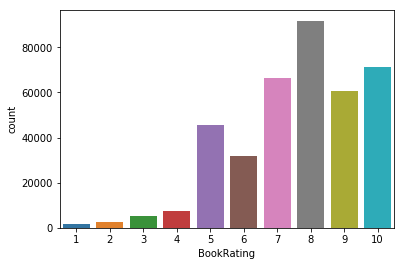

In [38]:
sns.countplot(data=exp_rate, x='BookRating')
plt.show()

We can see from the plot above that the majority of book ratings are ratings of 5 and higher. The rating of 8 has the highest frequency over 80,000 rates with 10 with slightly over 70,000 ratings. 
This could explain that most readers in this study are more satisfied with the books they're reading.

In [39]:
# Simple Popularity-based Recommendation System

In [40]:
rate_count = pd.DataFrame(exp_rate.groupby(['ISBN'])['BookRating'].count())
top10 = rate_count.sort_values('BookRating', ascending = False).head(10)
print("Following books are recommended")
top10.merge(books, left_index = True, right_on = 'ISBN')

Following books are recommended


,BookRating,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
408,707,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
26,581,0971880107,Wild Animus,Rich Shapero,2004,Too Far
748,487,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,383,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
1105,320,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
2143,313,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
356,307,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
706,295,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
305,281,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company
231,278,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books


Above displays the top 10 most popular books based on the amount of book ratings per book. We can see that 'The Lovely Bones' by Alice Sebold is most popular with 'Wild Animus' by Rich Shapero being second. 

## Model

In [41]:
# Collaborative Filtering-based Recommendation System

In [42]:
counts1 = exp_rate['UserID'].value_counts()
exp_rate = exp_rate[exp_rate['UserID'].isin(counts1[counts1 >= 3].index)]

In [43]:
counts = exp_rate['ISBN'].value_counts()
exp_rate = exp_rate[exp_rate['ISBN'].isin(counts[counts >= 10].index)]


Above, I filtered out users with less than 3 explicit book ratings and only considering users who rated 3 counts or more. I have also removed the books with less than 10 explicit ratings and only considering books with 10 or greater explicit ratings.

In [44]:
ratings_matrix = exp_rate.pivot(index='UserID', columns='ISBN', values='BookRating')
userID = ratings_matrix.index
isbn = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(16602, 4413)


ISBN,000649840X,0006547834,0006550576,0007110928,0007154615,000716226X,0020198817,0020198906,0020199600,0020427859,...,8445071416,8472236552,8477204055,8478884459,8478884955,8478886451,8495501090,8495501198,8495618605,8845205118
UserID,,,,,,,,,,,,,,,,,,,,,
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NaN values indicate an absence of ratings, which equates to sparse data. I've pivoted the explicit ratings into 'ratings_matrix' and displayed the dimensions for the matrix (16602, 4413). 

In [45]:
# SURPRISE

In [46]:
reader = surp.Reader(rating_scale=(1, 10))
data = surp.Dataset.load_from_df(exp_rate[['UserID','ISBN','BookRating']], reader)


In [47]:
#ISBN BookTitle BookAuthor YearOfPublication Publisher

benchmark = []
#'MAE','Time'

for algorithm in [SVD(), surp.SVDpp(), surp.SlopeOne(), surp.NMF(), surp.NormalPredictor(), surp.KNNBaseline(), surp.KNNBasic(), surp.KNNWithMeans(), surp.BaselineOnly(), surp.CoClustering()]:
 #Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, n_jobs=-1,verbose=True)
    
 # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6166  1.5936  1.5916  1.6006  0.0113  
MAE (testset)     1.2472  1.2376  1.2335  1.2395  0.0058  
Fit time          8.43    8.47    8.37    8.42    0.04    
Test time         0.56    0.54    0.54    0.54    0.01    
Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6193  1.6128  1.6071  1.6130  0.0050  
MAE (testset)     1.2462  1.2408  1.2371  1.2414  0.0037  
Fit time          80.11   79.98   77.35   79.15   1.27    
Test time         3.09    3.01    3.07    3.05    0.03    
Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.9431  1.9511  1.9533  1.9492  0.0044  
MAE (testset)     1.4570  1.4615  1.4616  1.4600  0.0021  
Fit time          1.25    1.24    1.24    1.24    0.01    
Test 

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.600597,1.239451,8.424961,0.544394
BaselineOnly,1.607126,1.253611,0.134451,0.403280
SVDpp,1.613034,1.241360,79.145472,3.053452
CoClustering,1.742499,1.311728,5.310202,0.439731
KNNBaseline,1.780329,1.353911,34.620789,4.880997
KNNWithMeans,1.843331,1.370796,27.831844,5.907692
KNNBasic,1.920624,1.468372,26.437182,5.398409
SlopeOne,1.949180,1.460035,1.243475,1.664827
NormalPredictor,2.407611,1.911973,0.170930,0.425890


3 fold cross validation is implemented above with with different functions in the Surprise package. Unfortunately, 5
fold cross validation cannot be completed due to memory/storage limits. Test time and Fit time tend to be near similar in all folds and the mean. 
Although, we can see that SVD has the best RMSE with BaselineOnly being a close second. 

In [48]:
# Tuning Parameters

In [49]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3,n_jobs=-1)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.6226648962779275
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


The best score is displayed being close to 1.62... using the best performing algorithm SVD. n_jobs = -1, equates to all CPU being utilized to run the whole grid with SVD. Performance measures for the grid search are RMSE and MAE.

## Conclusion

From this lab, I can conclude that there were multiple errors with run time and performance speed. There were many trials and errors due to testing the datasets. Eventually, I was able to test all the datasets successfully with successful content filtering and popularity recommender. Overall, the dataset was very sparse and had many NaN values, which required me to clean and reorganize the data for Book Ratings. In regards to the dataset, it contained higher explicit ratings (6-10) compared to lower explicit ratings (1-5). Although in total, Book Ratings had more Implicit Ratings compared to Explicit Ratings. Implicit Ratings are book ratings of 0. Explicit Ratings are book ratings of 1 to 10. I've noticed that running cross validation with more folds can affect the overall program performance speed. 